*Do not delete this style setting*

In [1]:
%%html
<style>
table {float:left}
</style>

# Session 1:<br>A simple QML model in PennyLane
<table>
    <tr><td><strong>Aim:</strong></td>
        <td>To explore the process of developing a <strong>PennyLane</strong> quantum model.<br/>Watch out for modeling pits and traps!</td></tr>
    <tr><td><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td><strong>Release:</strong></td>
        <td>April 2025</td></tr>
    <tr><td><strong>Datasets:</strong></td>
        <td>Use the following two data sets (code below):<br>
            <ol><li>$y = sin(x)$</li><li>$y = sin(0.7 x+0.5\pi)$</li></ol></td></tr>
    <tr><td><strong>Tasks:</strong></td>
        <td>40 minutes (unfinished tasks go to self-directed "challenges")</td></tr>
    <tr>
        <td></td>
        <td>Perform the following tasks<br>(record your observations at end of this notebook):<br><ol>
            <li>Initially use <strong><em>the first dataset</em></strong> and the <strong><em>simplistic model 1</em></strong> (as provided).<br>
                Follow the instructor demonstration to step through the code.</li>
            <li>Can you improve the selected model by<br>
                (you may need to increase the number of epochs):<br>
                - using more qubits and more layers ? (those of you with big computers)<br>
                - using fewer qubits and fewer layers ? (those of you with tiny laptops)<br>
                - changing the optimiser ? (leave it for later)</li>
            <li>Can the model work with a single qubit and single layer ?<br>If so, investigate...<br>
                - What happens when you change the data encoding gate from RY to RX ?<br>
                - Switch from basic (R gate with 1 param) to strongly entangled layers (3 params).<br>
                Any improvements ? If yes, why ? If not, why not ?</li><br>
                <em>The tasks below will be demonstrated by your instructor.</em><br>
                <em>However, we would like you to attempt them as challenge tasks.</em><br><br>
            <li>Try the current model with <strong><em>the second data set</em></strong><br>
                by commenting / uncommenting code in Data Generation section</li>
            <li>Can you improve the results by varying:<br>
                - the number of qubits ?<br>
                - the number of layers ?<br>
                - by increasing data range (say: -6..12) ?<br>
                - by adding more training data (say: 96) ?</li>
            <li>Can you improve the result by replicating data encoding block<br>
                - for all qubits by using the <strong><em>improved model 2</em></strong> ?<br>
                - in between entangling blocks by using the <strong><em>reuploading model 3</em></strong> ?<br>
                What are your insights from this exercise?</li>
            <li>Reflect on this session.</li>
        </ol></td>
    </tr>
    <tr>
        <td><strong>Challenge<br>Tasks:</strong></td>
        <td>Perform the following tasks in your own time:<br/><ol>
            <li>Complete the unfinished tasks.</li>
            <li>Is there a way of improving the model results for <strong><em>the second data set</em></strong> ?<br>
                <em>The answer will be revealed on <strong>day 2</strong> of the workshop !</em></li>
            <li>Write your own optimiser - see example at the end of the notebook.</li></ol>
        </td>
    </tr>
    <tr><td><strong>References:</strong></td>
        <td><a href="https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series" target="_blank">
            Maria Schuld and Johannes Jakob Meyer, "Quantum models as Fourier series",<br>PennyLane, November 6, 2024.</a></td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the
            <a href="https://creativecommons.org/licenses/by/4.0/" target="_blank">Creative Commons CC-BY</a></td></tr>
    <tr><td><strong>Changes:</strong></td>
        <td>All significant changes to this code must be listed at the bottom of this notebook.</td></tr>
</table>

In [2]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
import time

%matplotlib inline

## Settings

In [3]:
n_sample = 64
n_qubits = 2
n_layers = 4 # 6 (fast computers) # 2 and 1 (slow computers)
epochs = 20 # 50 (preferred) # 100 # 300 (may take hours)
seed = 2025

np.random.seed(seed)

## Data generation

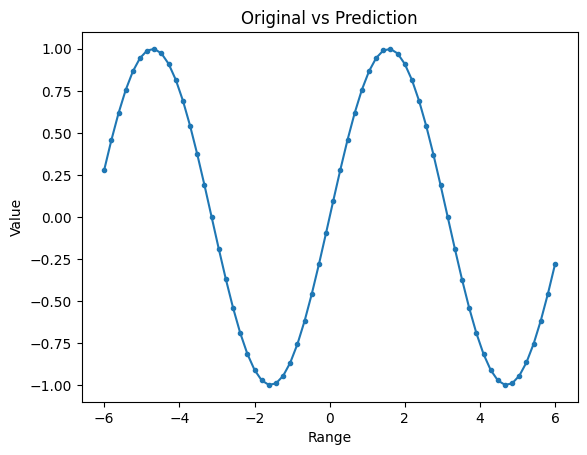

In [4]:
### Generate a data set
X = np.linspace(-6, 6, n_sample, requires_grad=False)
X = X.reshape((X.shape[0], 1))
y = np.sin(X[:,0], requires_grad=False)

### Switch to this data set
# X = np.linspace(-6, 6, n_sample, requires_grad=False)
# X = X.reshape((X.shape[0], 1))
# y = (np.sin(0.7*X[:,0]+0.5*np.pi, requires_grad=False)+1.0)*0.5

plt.title('Original vs Prediction')
plt.xlabel('Range')
plt.ylabel('Value')
plt.plot(X[:,0],y,'.-')
plt.show()

## Model definition

In [5]:
### A range of sample models to try (rename to "qnn_model")
### Device based on the lightning qubit could make it faster (not always)

dev = qml.device('default.qubit', wires=n_qubits, shots=None)
# dev = qml.device('lightning.qubit', wires=n_qubits, shots=None)

### Simplistic model
@qml.qnode(dev, diff_method='adjoint')
def qnn_model(params, x):
    
    # Data encoding
    qml.RY(x, wires=0)
    
    # Ansatz
    qml.BasicEntanglerLayers(params, wires=range(n_qubits), rotation=qml.RY)
    # qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
    
    return qml.expval(qml.PauliZ(0))

### Improved model (for more complex dataset)
@qml.qnode(dev, diff_method='adjoint')
def qnn_model_2(params, x):
    for q in range(n_qubits):
        qml.RY(x, wires=q)
    qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

### Reuploading model (for more complex dataset)
@qml.qnode(dev, diff_method='parameter-shift')
def qnn_model_3(params, x):
    for l in range(n_layers):
        for q in range(n_qubits):
            qml.RY(x, wires=q)
        qml.StronglyEntanglingLayers([params[l]], wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

## Loss and cost function
*Note that "mse_loss" cannot be replaced by sklearn "mean_squared_error", which does not understand gradients.*<br>
*When we switch to PyTorch, we will use its range of loss functions.*

In [6]:
### Our own gradient-friendly loss function
def mse_loss(targets, predictions):
    loss = 0
    for l, p in zip(targets, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(targets)
    return loss

### Note that this cost function uses globals
### which we will will show later how to improve
def cost_fun(params, inputs, targets):
    preds = [qnn_model(params, x) for x in inputs]
    return mse_loss(targets, preds)

## Explore the model structure

In [7]:
### Check the shape of your ansatz parameters

print(f'BasicEntanglerLayers shape: {qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_qubits)}')
print(f'StronglyEntanglingLayers shape: {qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)}')

BasicEntanglerLayers shape: (4, 2)
StronglyEntanglingLayers shape: (4, 2, 3)


In [8]:
### Check if the model works
### - Note that the shape of test params must match the model

# test_params = np.random.uniform(high=np.pi, size=(n_layers, n_qubits, 3), requires_grad=True)
test_params = np.random.uniform(high=np.pi, size=(n_layers, n_qubits), requires_grad=True)
test_data = X[0]
qnn_model(test_params, test_data)

array([-0.51205379])

In [9]:
### Plot the model circuit (in a "standard" text format)
### - Note that in PennyLane many utilities return functions 

print(f"\n{qml.draw(qnn_model, decimals=2, level='device')(test_params, test_data)}\n")


0: ──RY(-6.00)──RY(1.07)─╭●──RY(2.03)─╭●──RY(0.90)─╭●──RY(0.40)─╭●─┤  <Z>
1: ──RY(0.33)────────────╰X──RY(2.92)─╰X──RY(2.46)─╰X──RY(2.77)─╰X─┤     



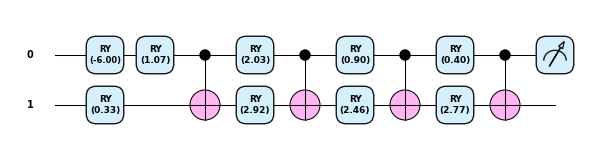

In [10]:
### Plot the model circuit nicely using matplotlib functions
### - Note that a more flexible circuit drawer can be found in utilities.py

qml.drawer.use_style('pennylane')
fig, ax = qml.draw_mpl(qnn_model, decimals=2, level='device')(test_params, test_data)
fig.set_dpi(fig.get_dpi()*0.5)
plt.show()

## Training loop

In [11]:
### Select one of the following optimisers built into PennyLane
# opt = qml.GradientDescentOptimizer(stepsize=0.5)
# opt = qml.RMSPropOptimizer(stepsize=0.1, decay=0.7, eps=1e-08)
opt = qml.AdamOptimizer(stepsize=0.5)
# opt = qml.NesterovMomentumOptimizer(stepsize=0.5)
# opt = RCDOptimizer(h=0.1)

### Select the initial parameters (match the ansatz shape)
# params = np.random.uniform(high=np.pi, size=(n_layers, n_qubits, 3), requires_grad=True)    
params = np.random.uniform(high=0.1, size=(n_layers, n_qubits), requires_grad=True)    

### Training loop
hist_cost = []
prompt_fract = 0.1
start_time = time.time() 
for iter in range(epochs):
    params, cost = opt.step_and_cost(lambda p: cost_fun(p, X, y), params)
    elapsed_time = time.time()-start_time
    hist_cost.append(cost)
    if (prompt_fract == 0) or (iter % int(prompt_fract*epochs) == 0):
        print(f'Iter: {iter:03d} ({int(elapsed_time):03d} sec) cost={np.round(cost.numpy(), 6)}')

### Print the training summary
min_cost = np.min(hist_cost)
min_iter = np.argmin(hist_cost)
print(f'\nTraining completed: epochs={epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

Iter: 000 (000 sec) cost=[1.07541]
Iter: 002 (000 sec) cost=[0.054548]
Iter: 004 (001 sec) cost=[0.006263]
Iter: 006 (002 sec) cost=[0.018751]
Iter: 008 (002 sec) cost=[0.003031]
Iter: 010 (003 sec) cost=[0.006749]
Iter: 012 (003 sec) cost=[0.016053]
Iter: 014 (004 sec) cost=[0.019435]
Iter: 016 (004 sec) cost=[0.00484]
Iter: 018 (005 sec) cost=[7.e-05]

Training completed: epochs=20, min cost=7e-05 @ 18, time=005 secs



## Plot the results
*Note that a more flexible performance and multi-curve plotters can be found in utilities.py*

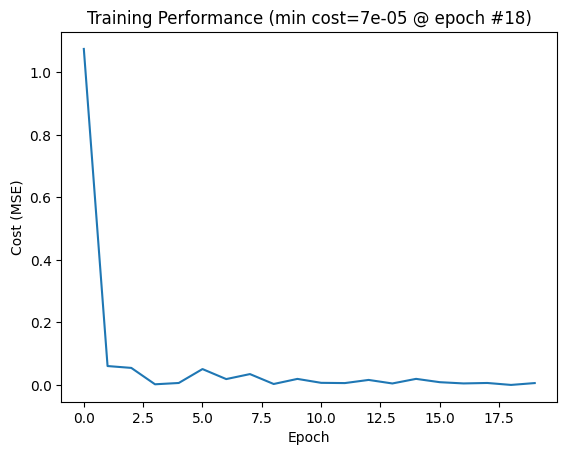

In [12]:
### Show training performance
plt.title(f'Training Performance (min cost={np.round(min_cost, 6)} @ epoch #{min_iter})')
plt.xlabel('Epoch')
plt.ylabel('Cost (MSE)')
plt.plot(hist_cost,'-')
plt.show()

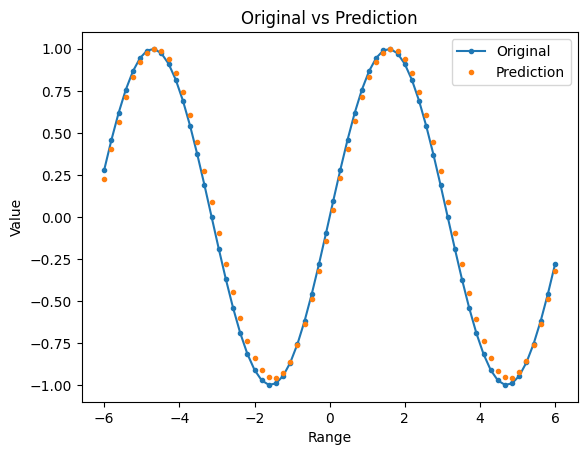

In [13]:
### Plot original vs prediction
y_pred = [qnn_model(params, x) for x in X]

plt.title('Original vs Prediction')
plt.xlabel('Range')
plt.ylabel('Value')
plt.plot(X[:,0], y, '.-', label='Original')
plt.plot(X[:,0], y_pred, '.', label='Prediction')
plt.legend(loc='best', ncol=1)
plt.show()

## Write your observations here

- Task 1:
- Task 2:
- Task 3:
- Task 4:
- Task 5:
- Task 6:
- Task 7:
- Challenge:
- Reflection:

## Challenge task:<br>Write your own optimiser (in own time)
**You can try using this Random Coordinate Descent (RCD) optimiser**<br>
*RCD is a gradient-based optimizer, so it uses the gradient of the cost function.<br>
This method updates one random parameter at the time, so it is very slow!<br>
However, think what would be the advantages of this approach!*<br/>
Ref: https://pennylane.ai/blog/2022/07/how-to-create-your-own-optimizer

In [14]:
class RCDOptimizer:
    def __init__(self, eta=0.01 , h=0.005):
        self.h = h
        self.eta = eta

    def step(self, objective_fn, theta):
        i = np.random.randint(theta.size)
        shape = theta.shape
        dt = np.eye(1,theta.size,i)
        theta = theta.reshape(-1)
        dtheta = (objective_fn((theta+dt*self.h).reshape(shape)) 
                    -objective_fn((theta-dt*self.h).reshape(shape)))/(2*self.h)
        return (theta - self.eta*dtheta*dt).reshape(shape)

    def step_and_cost(self, objective_fn, theta):
        theta = self.step(objective_fn, theta)
        return theta, objective_fn(theta)

## Software (Linux)

In [15]:
import os
os.system('pip list | grep -e PennyLane -e torch');

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
PennyLane_Lightning_GPU   0.40.0
PennyLane-Rigetti         0.40.0
torch                     2.6.0+cu126
torch-geometric           2.6.1
torchaudio                2.6.0+cu126
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cu126
